In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate
from matplotlib import pyplot as plt
import pyGadget

In [2]:
sns.set_context('poster')
plt.rcParams['text.usetex'] = True

#Calculate $N_{\rm \small effective}$ from $N_{\rm \small pole}$ and $N_{\rm \small equator}$.

###$N_{\rm \small effective} = N_{\rm \small pole} \frac{2 \Omega_{\rm \small pole}}{4\pi} + N_{\rm \small equator} \frac{4\pi - 2 \Omega_{\rm \small pole}}{4\pi}$

###$\Omega_{\rm \small pole} = \int_0^{2\pi}{\rm d}\phi \int_0^{\pi/4}{\rm sin}\theta \,{\rm d}\theta  = 2\pi \left( 1 - \frac{1}{\sqrt{2}} \right) \approx 2\pi \times 0.29289 = 1.840282$

#From our [fit](Local Optical Depth Prescription.ipynb),
##$N_{\rm \small pole} = 10^{0.532301 {\rm log_{10}}(n) + 19.636552}$ and $N_{\rm \small equator} = 10^{0.626204 {\rm log_{10}}(n) + 19.573490}$

In [3]:
def N_p(n):
    exponent = 0.532301 * np.log10(n) + 19.636552
    return 10**exponent

def N_eq(n):
    exponent = 0.626204 * np.log10(n) + 19.573490
    return 10**exponent

In [4]:
Omega_pole = 1.840282
fourpi = 4 * np.pi
a = 2 * Omega_pole / fourpi
b = (fourpi - 2*Omega_pole)/fourpi
def N_eff(n):
    x = N_p(n)
    y = N_eq(n)
    return a*x + b*y
N_eff(1e-2)

2.5741339677545175e+18

This algorithm is copied almost verbatim from what I've implemented in GADGET; it calculates the X-Ray heating and ionization for each species we're tracking. **Note: Technically, these are the rates/J$_0$.  J$_0$ depends on redshift, so that has to be included at runtime.**

In [5]:
def calculate_heat_ion_rates(rad_type, n):
    h_nu = 6.6262e-27
    h_eV = 4.13567e-15
    
    E_0 = 1e3
    E_min = 1e3
    E_max = 1e4

    i = 0
    ion_rate = 0.
    heat_rate = 0.
    N_i_steps = 1000

    if (rad_type == 'H'):
        Z = 1.
        nu_ion = 3.3e15
    elif rad_type == 'He':
        Z = 0.89
        nu_ion = 5.95e15
    elif rad_type == 'HeII':
        Z = 2.0
        nu_ion = 1.32e16
    else:
        raise KeyError

    nu_0 = E_0 / h_eV
    nu_min = E_min / h_eV
    nu_max = E_max / h_eV
    logvmin = np.log10(nu_min)
    logvmax = np.log10(nu_max)
    for i in range(N_i_steps):
        Freq = (logvmax - logvmin) / (N_i_steps) * (i + 0.5) + logvmin
        Freq_start = (logvmax - logvmin) / (N_i_steps) * (i) + logvmin
        Freq_end = (logvmax - logvmin) / (N_i_steps) * (i + 1.0) + logvmin
        Freq = np.power(10, Freq)
        Freq_start = np.power(10, Freq_start)
        Freq_end = np.power(10, Freq_end)
        DFreq = Freq_end - Freq_start
        
        F_nu = 4 * np.pi * np.power( Freq/nu_0, -1.5)
        epsilon = np.sqrt(Freq / nu_ion - 1.0)
        sigma = 6.3e-18 / np.power(Z,2.0) * np.power(nu_ion/Freq,4.0) \
            * np.exp(4.0 - (4.0*np.arctan(epsilon) / epsilon)) \
            / (1.0-np.exp(-2.0*np.pi / epsilon))
        
        ion_rate += F_nu * sigma * np.exp(-sigma * N_eff(n)) / (h_nu * Freq) * DFreq
        heat_rate += F_nu * sigma * np.exp(-sigma * N_eff(n)) * ( 1.0 - nu_ion / Freq ) * DFreq
    return ion_rate, heat_rate

In [6]:
n = 1e-50
print 'HI::'
a,b = calculate_heat_ion_rates('H', n)
print a, b
print 'HeI::'
a,b = calculate_heat_ion_rates('He', n)
print a, b
print 'HeII::'
a,b = calculate_heat_ion_rates('HeII', n)
print a, b

HI::
4504.78584835 8.98437771572e-06
HeI::
40519.8843969 8.02736154381e-05
HeII::
108864.24469 0.000211269398402


$$\sigma^{i}(\nu) = 6.30\times10^{-18} {\rm cm}^2 \times \frac{1}{Z_i^2} \left(\frac{\nu_{\rm \small ion}}{\nu} \right)^4 
\frac{{\rm e}^{4-(4 {\rm tan}^{-1} \epsilon)/\epsilon}}{1-{\rm e}^{-2\pi / \epsilon}}; \quad
\epsilon(\nu, \nu_{\rm \small ion}) = \sqrt{\frac{\nu}{\nu_{\rm \small ion}-1}} $$

In [7]:
def sigma(freq, species):
    def epsilon(nu, nu_ion):
        return np.sqrt(nu / nu_ion - 1.0)
    
    if (species == 'H'):
        Z = 1.
        nu_ion = 3.3e15
    elif (species == 'He'):
        Z = 0.89
        nu_ion = 5.95e15
    elif (species == 'HeII'):
        Z = 2.0
        nu_ion = 1.32e16
    else:
        raise KeyError

    ep = epsilon(freq, nu_ion)
    x =  np.exp(4.0 - (4.0*np.arctan(ep) / ep)) / (1.0-np.exp(-2.0*np.pi / ep))
    return x * 6.3e-18 / np.power(Z,2.0) * np.power(nu_ion/freq,4.0) 

$$F_{\rm \small XR}(z,\nu) = 4\pi \times J_{\rm \small XR}(z,\nu) = 4\pi \times J_0(z) \left(\frac{\nu}{\nu_0}\right)^{-1.5}$$

In [8]:
def normed_flux(J0, nu, nu_0, alpha):
    return 4 * np.pi * J0 * np.power(nu/nu_0, alpha)

$$\frac{F_{\rm \small XR}(z,\nu)}{J_0(z)} = 4\pi \left(\frac{\nu}{\nu_0}\right)^{-1.5}$$

In [9]:
def unnormed_flux(nu, nu_0, alpha):
    return 4 * np.pi * np.power(nu/nu_0, alpha)

$$ {\rm k}^i_{\rm \small ion, p}(z, n) = \int_{1 {\rm keV}}^{10 {\rm keV}} \frac{F_{\rm \small XR}(z,\nu) \sigma^{i}_{\nu}}{h\nu} {\rm e}^{- \sigma^{i}_{\nu} N_{\rm \small eff}(n)} d\nu; \quad 
\Gamma_{\rm \small XR} = n \int_{1 {\rm keV}}^{10 {\rm keV}} F_{\rm \small XR}(z,\nu) \sigma^i_{\nu}
\left(1 - \frac{\nu_{\rm ion}}{\nu} \right) {\rm e}^{- \sigma^{i}_{\nu} N_{\rm \small eff}(n)} d\nu$$

In [10]:
def k_integrand(frequency, species, nu_0, alpha, n, attenuation=True, tau=None, tau_sig=None):
    h_nu = 6.6262e-27
    f_nu = unnormed_flux(frequency, nu_0, alpha)
    sigma_nu = sigma(frequency, species)
    if attenuation:
        if tau is None:
            if tau_sig is None:
                tau = - sigma_nu * N_eff(n)
            else:
                tau = - tau_sig * N_eff(n)
        return f_nu * sigma_nu * np.exp(tau) / (h_nu * frequency)
    else:
        return f_nu * sigma_nu / (h_nu * frequency)

def h_integrand(frequency, species, nu_0, alpha, n, attenuation=True, tau=None, tau_sig=None):
    h_nu = 6.6262e-27
    if (species == 'H'):
        nu_ion = 3.3e15
    elif (species == 'He'):
        nu_ion = 5.95e15
    elif (species == 'HeII'):
        nu_ion = 1.32e16
    else:
        raise KeyError

    f_nu = unnormed_flux(frequency, nu_0, alpha)
    sigma_nu = sigma(frequency, species)
    if attenuation:
        if tau is None:
            if tau_sig is None:
                tau = - sigma_nu * N_eff(n)
            else:
                tau = - tau_sig * N_eff(n)
        return f_nu * sigma_nu * np.exp(tau) * (1.0 - nu_ion / frequency)
    else:
        return f_nu * sigma_nu * (1.0 - nu_ion / frequency)

In [11]:
h_eV = 4.13567e-15
E_0 = 1e3
E_min = 1e3
E_max = 1e4

In [12]:
integrate.quad(k_integrand, E_min/h_eV, E_max/h_eV, args=('H', E_0/h_eV, -1.5, 1e-50))

(4504.8082161801185, 1.1508018119823701e-08)

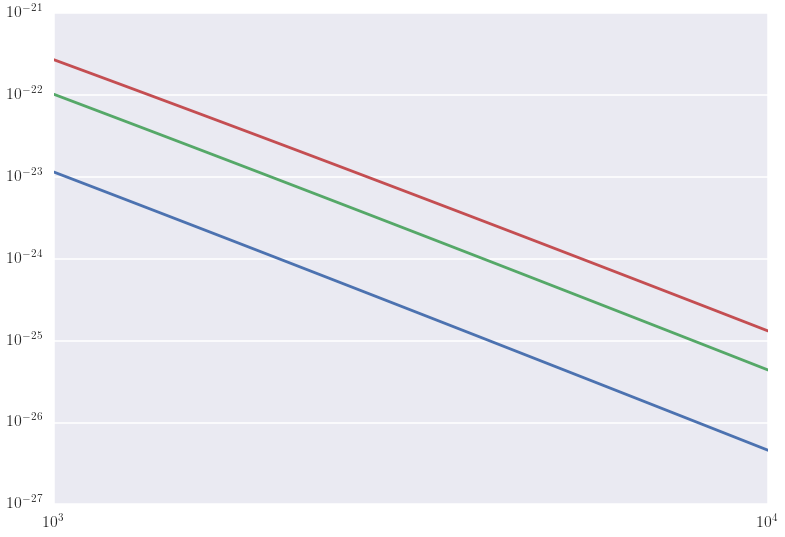

In [13]:
e_xr = np.logspace(3, 4, 100)
plt.loglog(e_xr, sigma(e_xr/h_eV, 'H'))
plt.loglog(e_xr, sigma(e_xr/h_eV, 'He'))
plt.loglog(e_xr, sigma(e_xr/h_eV, 'HeII'))

In [14]:
@np.vectorize
def k_rates(n, species, attenuation=True, tau=None, tau_sig=None):
    h_eV = 4.13567e-15
    E_0 = 1e3
    E_min = 1e3
    E_max = 1e4
    alpha = -1.5
    ans, err = integrate.quad(k_integrand, E_min/h_eV, E_max/h_eV, args=(species, E_0/h_eV, alpha, n, attenuation, tau, tau_sig))
    return ans

@np.vectorize
def h_rates(n, species, attenuation=True, tau=None, tau_sig=None):
    h_eV = 4.13567e-15
    E_0 = 1e3
    E_min = 1e3
    E_max = 1e4
    alpha = -1.5
    ans, err = integrate.quad(h_integrand, E_min/h_eV, E_max/h_eV, args=(species, E_0/h_eV, alpha, n, attenuation, tau, tau_sig))
    return ans

In [15]:
k_rates(1e-50, 'H')

array(4504.8082161801185)

In [16]:
(12 - -4)*5+1

81

In [17]:
attenuation = True
n = np.logspace(-4,12.2,82)
nhe = .1*n
nhep = nhe/1e3
kh_rates = pd.DataFrame(index=np.linspace(-4,12.2,82))
kh_rates['kH'] = k_rates(n, 'H', attenuation)
kh_rates['kHe'] = k_rates(nhe, 'He', attenuation)
kh_rates['kHeII'] = k_rates(nhe, 'HeII', attenuation)
kh_rates['hH'] = h_rates(n, 'H', attenuation)
kh_rates['hHe'] = h_rates(nhe, 'He', attenuation)
kh_rates['hHeII'] = h_rates(nhep, 'HeII', attenuation)
kh_rates['nhH'] = h_rates(n, 'H', attenuation) * n
kh_rates['nhHe'] = h_rates(nhe, 'He', attenuation) * nhe
kh_rates['nhHeII'] = h_rates(nhep, 'HeII', attenuation) * nhep

In [18]:
attenuation = False
n = np.logspace(-4,12.2,82)
nhe = .1*n
nhep = nhe/1e3
khr = pd.DataFrame(index=np.linspace(-4,12.2,82))
khr['kH'] = k_rates(n, 'H', attenuation)
khr['kHe'] = k_rates(nhe, 'He', attenuation)
khr['kHeII'] = k_rates(nhep, 'HeII', attenuation)
khr['hH'] = h_rates(n, 'H', attenuation)
khr['hHe'] = h_rates(nhe, 'He', attenuation)
khr['hHeII'] = h_rates(nhep, 'HeII', attenuation)
khr['nhH'] = h_rates(n, 'H', attenuation) * n
khr['nhHe'] = h_rates(nhe, 'He', attenuation) * nhe
khr['nhHeII'] = h_rates(nhe, 'HeII', attenuation) * nhep

In [19]:
kh_rates.head(3)

,kH,kHe,kHeII,hH,hHe,hHeII,nhH,nhHe,nhHeII
-4.0,3567.732195,22533.274398,27278.478099,0.000007,0.000048,0.000203,7.286014e-10,4.766328e-10,2.034700e-12
-3.8,3350.844076,19420.998862,20417.416874,0.000007,0.000042,0.000201,1.091962e-09,6.637970e-10,3.191481e-12
-3.6,3096.880098,16208.436169,14824.927302,0.000006,0.000036,0.000199,1.613650e-09,9.003454e-10,4.991732e-12


In [20]:
kh_rates.tail(3)

,kH,kHe,kHeII,hH,hHe,hHeII,nhH,nhHe,nhHeII
11.8,0,0,0,0,0,0,0,0,0
12.0,0,0,0,0,0,0,0,0,0
12.2,0,0,0,0,0,0,0,0,0


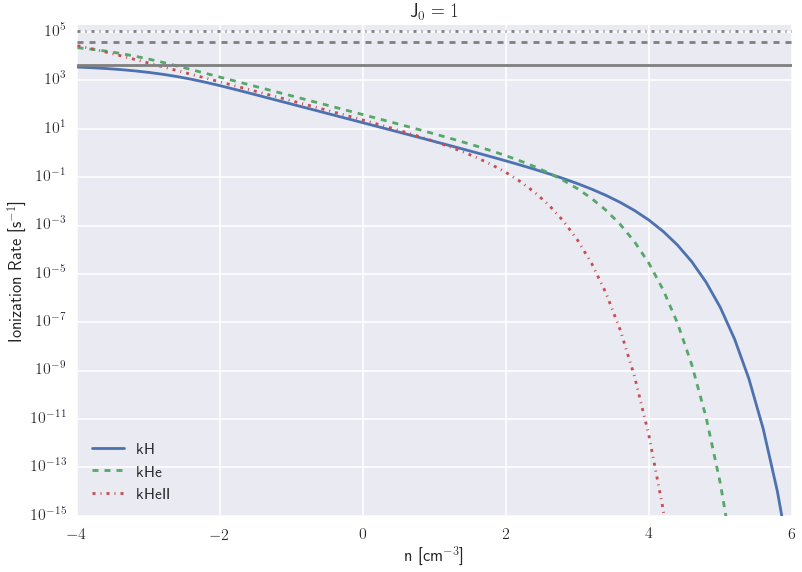

In [21]:
kh_rates[['kH', 'kHe', 'kHeII']].plot(logy=True, ylim=(1e-15, 2e5), xlim=(-4,6), style=['-', '--', '-.'])
plt.plot(khr.index, khr.kH, '-', color='grey')
plt.plot(khr.index, khr.kHe, '--', color='grey')
plt.plot(khr.index, khr.kHeII, '-.', color='grey')
plt.xlabel('n [cm$^{-3}$]')
plt.ylabel('Ionization Rate [s$^{-1}$]')
plt.title('J$_0 = 1$')
plt.savefig('figures/khrates/ionrate.png', bbox_inches='tight')

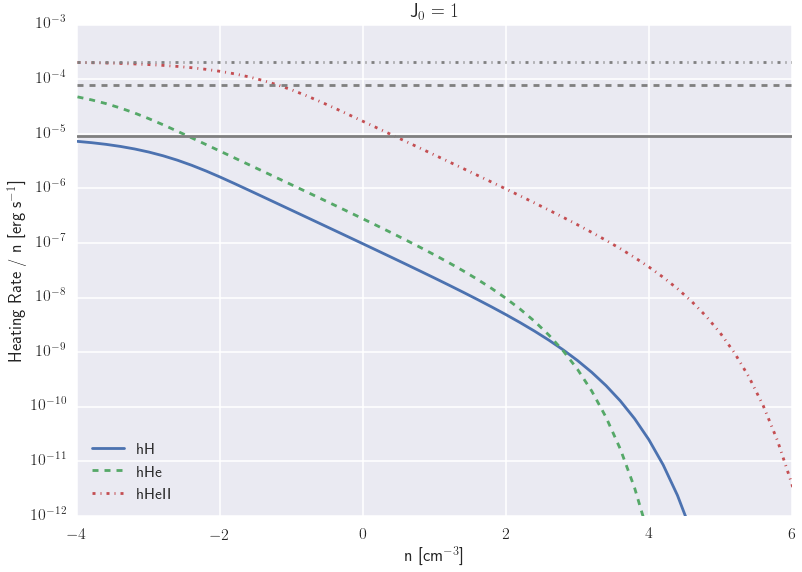

In [22]:
kh_rates[['hH', 'hHe', 'hHeII']].plot(logy=True, ylim=(1e-12, 1e-3), xlim=(-4,6), style=['-', '--', '-.'])
plt.plot(khr.index, khr.hH, '-', color='grey')
plt.plot(khr.index, khr.hHe, '--', color='grey')
plt.plot(khr.index, khr.hHeII, '-.', color='grey')
plt.xlabel('n [cm$^{-3}$]')
plt.ylabel('Heating Rate / n [erg s$^{-1}$]')
plt.title('J$_0 = 1$')
plt.savefig('figures/khrates/hrate.png', bbox_inches='tight')

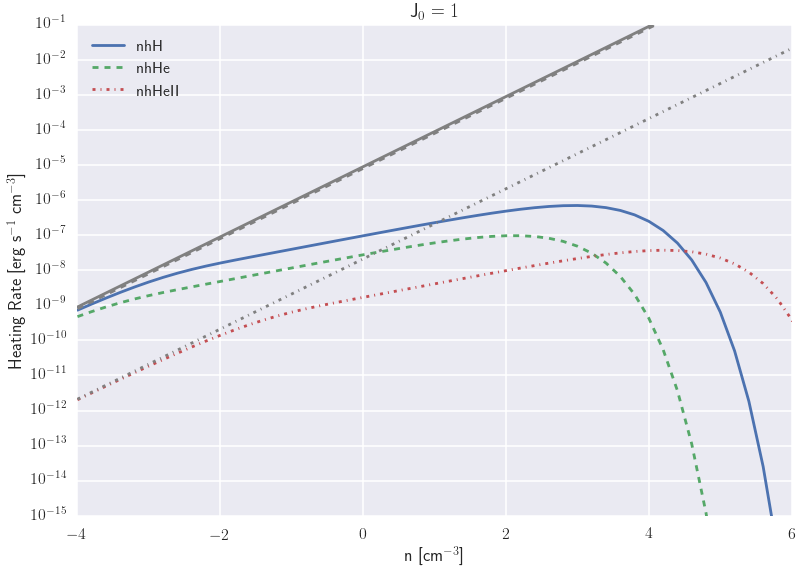

In [23]:
kh_rates[['nhH', 'nhHe', 'nhHeII']].plot(logy=True, ylim=(1e-15, 1e-1), xlim=(-4,6), style=['-', '--', '-.'])
plt.plot(khr.index, khr.nhH, 'grey')
plt.plot(khr.index, khr.nhHe, '--', color='grey')
plt.plot(khr.index, khr.nhHeII, '-.', color='grey')
plt.xlabel('n [cm$^{-3}$]')
plt.ylabel('Heating Rate [erg s$^{-1}$ cm$^{-3}$]')
plt.title('J$_0 = 1$')
plt.savefig('figures/khrates/nhrate.png', bbox_inches='tight')

###### As currently designed, the optical depth for each individual species is calculated using the total column density.  Thinking I probably need to use the column density specific to each species.

In [24]:
kh_data = np.column_stack((kh_rates.index.values, kh_rates[['kH', 'kHe', 'kHeII', 'hH', 'hHe', 'hHeII']].values))

In [25]:
kh_data.shape

(82, 7)

In [26]:
np.savetxt('kh_rates.dat', kh_data, fmt='%.8e %.8e %.8e %.8e %.8e %.8e %.8e')

In [27]:
!head kh_rates.dat

-4.00000000e+00 3.56773219e+03 2.25332744e+04 2.72784781e+04 7.28601364e-06 4.76632830e-05 2.03469971e-04
-3.80000000e+00 3.35084408e+03 1.94209989e+04 2.04174169e+04 6.88981207e-06 4.18827565e-05 2.01368856e-04
-3.60000000e+00 3.09688010e+03 1.62084362e+04 1.48249273e+04 6.42405591e-06 3.58433957e-05 1.98724424e-04
-3.40000000e+00 2.80626738e+03 1.30542021e+04 1.05355066e+04 5.88833263e-06 2.98163653e-05 1.95410021e-04
-3.20000000e+00 2.48308726e+03 1.01309875e+04 7.39906090e+03 5.28850278e-06 2.41065312e-05 1.91277861e-04
-3.00000000e+00 2.13610065e+03 7.58887632e+03 5.17236634e+03 4.63862951e-06 1.89917717e-05 1.86160730e-04
-2.80000000e+00 1.77908835e+03 5.51795876e+03 3.61195597e+03 3.96182226e-06 1.46580307e-05 1.79877655e-04
-2.60000000e+00 1.42986740e+03 3.92928552e+03 2.52234656e+03 3.28888184e-06 1.11616095e-05 1.72245715e-04
-2.40000000e+00 1.10756292e+03 2.76629470e+03 1.76175813e+03 2.65394610e-06 8.44070737e-06 1.63100467e-04
-2.20000000e+00 8.28475380e+02 1.93892462e+03 

In [28]:
!tail kh_rates.dat

1.04000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.06000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.08000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.10000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.12000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.14000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.16000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.18000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.20000000e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
1.22000000e+01 0.00000000e+00 0.00000000e+00 0.00000000

## Testing/Verification

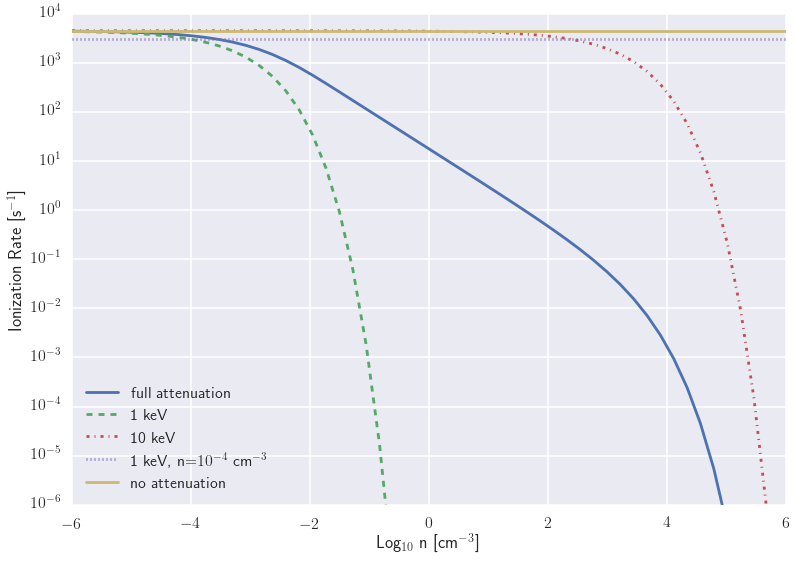

In [29]:
n = np.logspace(-6,12.2,82)
ktest = pd.DataFrame(index=np.linspace(-6,12.2,82))
ktest['full attenuation'] = k_rates(n, 'H', True)
ktest['1 keV'] = k_rates(n, 'H', True, tau_sig=1.14e-23)
ktest['10 keV'] = k_rates(n, 'H', True, tau_sig=4.54e-27)
ktest['1 keV, n=$10^{-4}$ cm$^{-3}$'] = k_rates(n, 'H', True, tau=-1.14e-23*N_eff(1e-4))
ktest['no attenuation'] = k_rates(n, 'H', False)
ktest.plot(logy=True, ylim=(1e-6, 1e4), xlim=(-6,6), style=['-', '--', '-.',':'])
plt.xlabel('Log$_{10}$ n [cm$^{-3}$]')
plt.ylabel('Ionization Rate [s$^{-1}$]')
plt.savefig('figures/khrates/ktest.png', bbox_inches='tight')

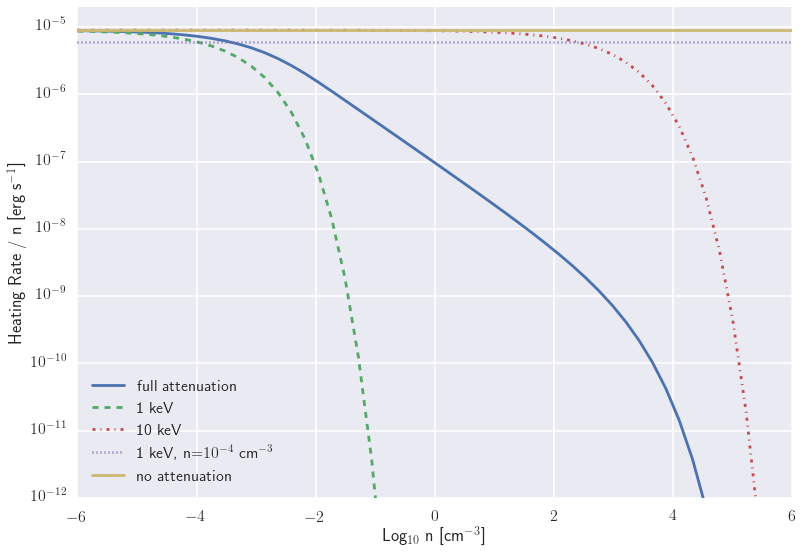

In [30]:
n = np.logspace(-6,12.2,82)
htest = pd.DataFrame(index=np.linspace(-6,12.2,82))
htest['full attenuation'] = h_rates(n, 'H', True)
htest['1 keV'] = h_rates(n, 'H', True, tau_sig=1.14e-23)
htest['10 keV'] = h_rates(n, 'H', True, tau_sig=4.54e-27)
htest['1 keV, n=$10^{-4}$ cm$^{-3}$'] = h_rates(n, 'H', True, tau=-1.14e-23*N_eff(1e-4))
htest['no attenuation'] = h_rates(n, 'H', False)
htest.plot(logy=True, ylim=(1e-12, 2e-5), xlim=(-6,6), style=['-', '--', '-.', ':'])
plt.xlabel('Log$_{10}$ n [cm$^{-3}$]')
plt.ylabel('Heating Rate / n [erg s$^{-1}$]')
plt.savefig('figures/khrates/htest.png', bbox_inches='tight')

# Ionization vs Recombination:

In [31]:
bkg = {'vanilla':0, 'xr_tau_J0': 1e0, 'xr_tau_J1': 1e1, 'xr_tau_J2': 1e2, 'xr_tau_J3': 1e3}

In [32]:
def find_closest(A, target):
    #A must be sorted
    idx = A.searchsorted(target)
    idx = np.clip(idx, 1, len(A)-1)
    left = A[idx-1]
    right = A[idx]
    idx -= target - left < right - target
    return idx

In [33]:
jxr = pd.read_csv('jxr.dat', delim_whitespace=True, names=['z', 'J0'])
jxr.sort('z', inplace=True)

In [34]:
simV = pyGadget.sim.Simulation('stampede/vanilla',length='pc', refine=False)
sim0 = pyGadget.sim.Simulation('stampede/xr_tau_J0',length='pc', refine=False)
sim1 = pyGadget.sim.Simulation('stampede/xr_tau_J1',length='pc', refine=False)
sim2 = pyGadget.sim.Simulation('stampede/xr_tau_J2',length='pc', refine=False)
sim3 = pyGadget.sim.Simulation('stampede/xr_tau_J3',length='pc', refine=False)
sims = [simV, sim0, sim1, sim2, sim3]
simlist = ['vanilla', 'xr_tau_J0', 'xr_tau_J1', 'xr_tau_J2', 'xr_tau_J3']
nsnap = [355, 306, 327, 271, 235]
snaps= {}
for name, n, sim in zip(simlist, nsnap, sims):
    s = sim.load_snapshot(n)
    snaps[name] = s
simname = {'vanilla':r'J = 0',
        'xr_tau_J0': r'J = J$_{0}$', 
        'xr_tau_J1': r'J = 10 J$_{0}$', 
        'xr_tau_J2': r'J = 10$^2$ J$_{0}$',
        'xr_tau_J3': r'J = 10$^3$ J$_{0}$'}

In [35]:
hydrogen = kh_rates[['kH', 'hH', 'hHe']].reset_index()
hydrogen.columns = ['log_n', 'ion_tau', 'gammaH', 'gammaHe']

In [36]:
abHe = .06/.76
store = pd.HDFStore(os.getenv("HOME")+'/data/simdata/xrays/binned_averages.hdf5')
combined = {}
for sim in simname.keys():
    df = store[sim]
    df = hydrogen.join(df.reset_index(), how='inner')
    combined[sim] = df[np.isfinite(df.ID)]
store.close()

In [37]:
for sim in simname.keys():
    snap = snaps[sim]
    z, J0 = jxr.iloc[find_closest(jxr.z.values, snap.header.Redshift)]
    print sim, snap.header.Redshift, J0
    df = combined[sim]
    df['k_rec'] = df.ndensity * df.efrac * 4e-11 * df.temp**-.5
    df['abHI'] = 1.0 - 2*df.abH2 - df.abHp - df.abHD
    df['abHeI'] = abHe - df.abHep - df.abHepp
    df['fH_ion'] = 0.3908 * (1.0 - df.abHp**(0.4092))**(1.7592)
    #df['fHe_ion'] = 0.0554 * (1.0 - df.abHp**(0.4614))**(1.6660)
    df['ion_sec'] = (df.abHI*df.gammaH + df.abHeI*df.gammaHe) * df.fH_ion / (13.6 * 1.60217646e-12)
    df['ion_tot'] = J0*bkg[sim] * (df.ion_tau + df.ion_sec)
    df['ion_free'] = k_rates(df.logn, 'H', tau=False)

xr_tau_J3 25.8351456276 1.87932269e-24
xr_tau_J2 25.3221015225 2.35822527e-24
vanilla 25.0414341057 2.65214011e-24
xr_tau_J0 25.0652194139 2.61665951e-24
xr_tau_J1 25.1496056928 2.53122774e-24


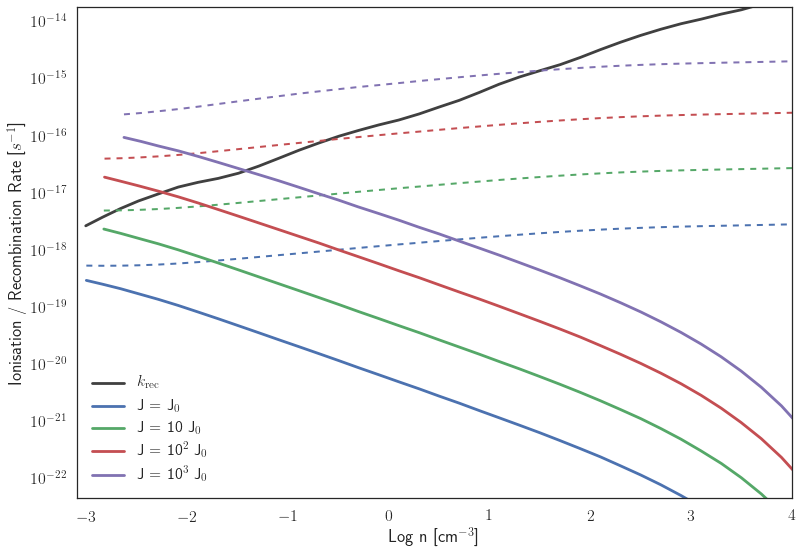

In [39]:
with sns.axes_style("white"):
    with sns.color_palette(n_colors=4):
        f,ax = plt.subplots()
df = combined['vanilla']
ax.semilogy(df.logn, df.k_rec, color='.25', ls='-', label=r' $k_{\rm \small rec}$')
#for sim in simlist[1:]:
#    snap = snaps[sim]
#    z, J0 = jxr.iloc[find_closest(jxr.z.values, snap.header.Redshift)]
#    df = combined[sim]
#    ax.semilogy(df.logn, J0*bkg[sim] * df.ion_tau, '--', alpha=.4)
for sim in simlist[1:]:
    df = combined[sim]
    ax.semilogy(df.logn, df.ion_tot/df.ion_tau*df.ion_free, ls='--', lw=2)

#for sim in simlist[1:]:
#    df = combined[sim]
#    ax.plot(df.logn, df.k_rec, ls='-', lw=4)
for sim in simlist[1:]:
    snap = snaps[sim]
    z, J0 = jxr.iloc[find_closest(jxr.z.values, snap.header.Redshift)]
    df = combined[sim]
    ax.semilogy(df.logn, df.ion_tot, ls='-', label=simname[sim])



ax.legend(loc=0)
ax.set_xlim(-3.1, 4)
ax.set_ylim(5e-23, 2e-14)
ax.set_xlabel('Log n [cm$^{-3}$]')
ax.set_ylabel('Ionisation / Recombination Rate [$s^{-1}$]')
f.savefig('figures/phase_diagrams/k_ion-k_rec.png', bbox_inches='tight')